In [2]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

%config InlineBackend.figure_format='svg'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt



ModuleNotFoundError: No module named 'matplotlib'

In [14]:
trajectories_df = pd.read_csv('../data/raw/trajectories_df-20240514.csv',
                              index_col=0,
                              dtype = {'FlightID': str, 'Bird': str, 'Age': int,
                                       'Category':str,'Iteration':int,'Time':float,
                                       'Frame': int,'X':float,'Y':float,'Z':float})   



In [16]:
sub_df = trajectories_df[trajectories_df.Category == 'Pre-wind']
sub_df

,FlightID,Bird,Age,Category,Iteration,Marker,Time,Frame,X,Y,Z,BirdID,Brood,Order,Mass_40,Chord_40
23520,0201040LN01,purpleR,40,Pre-wind,1,0,0.008333,1,70.326300,1034.77530,1179.2844,201,B,1,17.2,58.5
23521,0201040LN01,purpleR,40,Pre-wind,1,0,0.016667,2,69.573630,1034.69350,1184.2308,201,B,1,17.2,58.5
23522,0201040LN01,purpleR,40,Pre-wind,1,0,0.025000,3,69.099205,1034.85620,1188.9563,201,B,1,17.2,58.5
23523,0201040LN01,purpleR,40,Pre-wind,1,0,0.033333,4,68.577840,1035.16020,1193.6866,201,B,1,17.2,58.5
23524,0201040LN01,purpleR,40,Pre-wind,1,0,0.041667,5,68.079130,1035.46830,1198.1075,201,B,1,17.2,58.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9231021,1602040LN24,pinkR-turquoiseL,40,Pre-wind,24,4,3.966667,476,-18.025013,-335.56950,1439.7946,1602,F,2,15.2,60.0
9231022,1602040LN24,pinkR-turquoiseL,40,Pre-wind,24,4,3.975000,477,-17.708857,-334.03757,1440.6256,1602,F,2,15.2,60.0
9231023,1602040LN24,pinkR-turquoiseL,40,Pre-wind,24,4,3.983333,478,-17.243382,-332.11694,1442.1188,1602,F,2,15.2,60.0
9231024,1602040LN24,pinkR-turquoiseL,40,Pre-wind,24,4,3.991667,479,-16.730790,-329.90800,1443.1950,1602,F,2,15.2,60.0


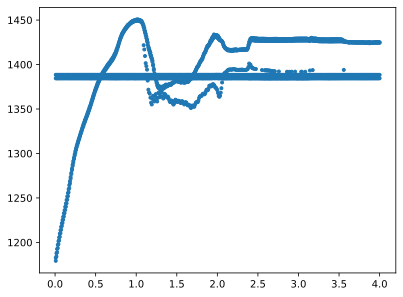

In [21]:
fig, ax = plt.subplots()

current_sequence = sub_df[sub_df.FlightID == '0201040LN01']
ax.plot(current_sequence.Time, current_sequence.Z, '.', label='0201040LN01')
plt.show()